In [1]:
from pathlib import Path
import pickle
import copy

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd()

# Setting up the system

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
]

polarizations = [
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
    [
        couplings.polarization_σp,
        couplings.polarization_σm,
    ],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.states.CoupledBasisState(
            J=1,
            F1=1 / 2,
            F=1,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            P=-1,
            Ω=0,
            electronic_state=states.ElectronicState.X,
        ),
        1
        * states.states.CoupledBasisState(
            J=1,
            F1=1 / 2,
            F=1,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            P=-1,
            Ω=0,
            electronic_state=states.ElectronicState.X,
        ),
    ],
    excited_mains=[
        1
        * states.states.CoupledBasisState(
            J=1,
            F1=1 / 2,
            F=0,
            mF=0,
            I1=1 / 2,
            I2=1 / 2,
            P=+1,
            Ω=1,
            electronic_state=states.ElectronicState.B,
        ),
        1
        * states.states.CoupledBasisState(
            J=1,
            F1=1 / 2,
            F=1,
            mF=0,
            I1=1 / 2,
            I2=1 / 2,
            P=+1,
            Ω=1,
            electronic_state=states.ElectronicState.B,
        ),
    ],
)

In [5]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,
    Ω1=hamiltonian.Γ,
    δ1=0.0,
    # polarization modulation
    Pl0="sin(ωl*t+ϕl0)",
    Pσp0="Pl0<0",
    Pσm0="Pl0>=0",
    Pl1="sin(ωl*t+ϕl1)",
    Pσp1="Pl1<0",
    Pσm1="Pl1>=0",
    ωl=2 * np.pi * 1e6,
    ϕl0=0.0,
    ϕl1=0.0,
)

In [6]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 24 s
Wall time: 42 s


In [9]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_original, transition_selectors, odepars
)

In [10]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)

# Single parameter only

In [11]:
for coupling in obe_system.couplings:
    print(
        round(
            utils.rabi.intensity_to_rabi(
                10e-3 / (25.4e-3 * 25.4e-3),
                coupling.main_coupling.real,
                D=2.6675506e-30,
            )
            / hamiltonian.Γ,
            3,
        )
    )

0.139
-0.128


In [12]:
odepars.Ω0 = 0.139 * hamiltonian.Γ
odepars.Ω1 = 0.128 * hamiltonian.Γ
odepars.δ0 = 0.0 * hamiltonian.Γ
odepars.δ1 = 0.0 * hamiltonian.Γ
odepars.ωl = 0.05 * hamiltonian.Γ
odepars.ϕl1 = 1 / 2 * np.pi
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)

In [13]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J1 = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
indices_J1 = qn_select_J1.get_indices(obe_system.QN)

qn_select_J3 = states.QuantumSelector(J=3, electronic=states.ElectronicState.X)
indices_J3 = qn_select_J3.get_indices(obe_system.QN)

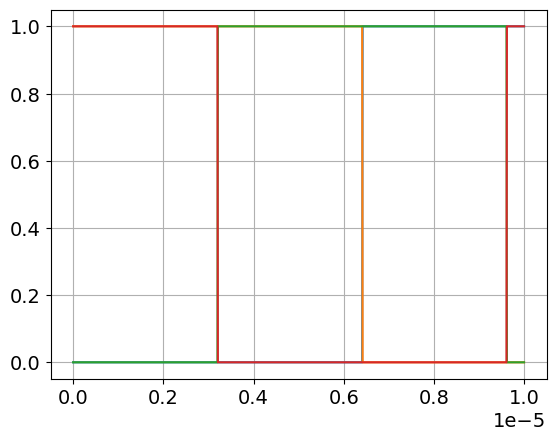

In [14]:
_t = np.linspace(0, 10e-6, 1001)
y0 = odepars.get_parameter_evolution(_t, "Pσp0")
y1 = odepars.get_parameter_evolution(_t, "Pσm0")
y2 = odepars.get_parameter_evolution(_t, "Pσp1")
y3 = odepars.get_parameter_evolution(_t, "Pσm1")

fig, ax = plt.subplots()
ax.plot(_t, y0)
ax.plot(_t, y1)
ax.plot(_t, y2)
ax.plot(_t, y3)

ax.grid()

6.92 photons


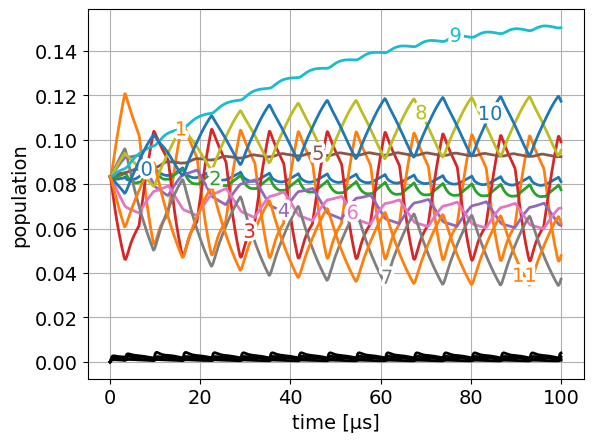

In [15]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2, label=indices_J1)

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

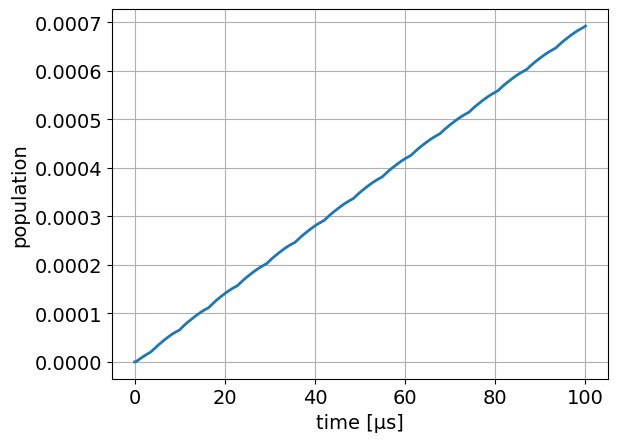

In [16]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J3].T, lw=2)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()